## Create model with PetitRadtrans

In [1]:
from sys import path
# path.append('/home/adb/PycharmProjects/')
path.append('/home/ldang05/Starships_prj/')



In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib  inline

In [5]:
from astropy import constants as const
from astropy import units as u

In [6]:
# import starships.planet_obs as pl_obs
from starships.planet_obs import Planet

# pl_obs=reload(pl_obs)

# import starships.planet_obs as pl_obs
# from starships.planet_obs import Observations,Planet
# 
# pl_obs=reload(pl_obs)

In [7]:
# pl_name = 'WASP-33 b'
# planet_obj=Planet(pl_name)
# planet_obj.ap = 0.0259*u.au
# planet_obj.R_star = (planet_obj.ap/3.69).to(u.R_sun)
# planet_obj.R_pl = (0.1143*planet_obj.R_star).to(u.R_jup)
# planet_obj.M_star = 1.561*const.M_sun

# pl_name = 'WASP-77 A b'
# planet_obj=Planet(pl_name)
# planet_obj.ap = 0.02335*u.au # semi-major axis
# planet_obj.R_star = 0.91*u.R_sun # star radius
# planet_obj.R_pl = 1.23*u.R_jup # planet radius
# planet_obj.M_star = 0.903*const.M_sun

# http://exoplanet.eu/catalog/corot-2_b/
pl_name = 'CoRoT-2 b'
planet_obj=Planet(pl_name)
planet_obj.ap = 0.0281*u.au # semi-major axis
planet_obj.R_star = 0.902*u.R_sun # star radius
planet_obj.R_pl = 1.465*u.R_jup # planet radius
planet_obj.M_star = 0.97*const.M_sun

Getting CoRoT-2 b from ExoFile


/home/ldang05/venv/ss-env/lib/python3.9/site-packages/exofile/archive.py:351: GetLocalFileWarning: DID NOT READ CUSTOM FILE. FileNotFoundError has occur when trying to query/read custom file.
  warn(GetLocalFileWarning(file="custom file", err=e))


In [8]:
planet_obj.all_params
# planet_obj.Tp # planet temperature
# planet_obj.period.to('d')

pl_name,pl_letter,hostname,hd_name,hip_name,tic_id,disc_pubdate,disc_year,discoverymethod,disc_locale,disc_facility,disc_instrument,disc_telescope,disc_refname,ra,rastr,dec,decstr,glon,glat,elon,elat,ra_reflink,pl_orbper,pl_orbpererr1,pl_orbpererr2,pl_orbperlim,pl_orbperstr,pl_orbper_reflink,pl_orblpererr1,pl_orblper,pl_orblpererr2,pl_orblperlim,pl_orblperstr,pl_orblper_reflink,pl_orbsmax,pl_orbsmaxerr1,pl_orbsmaxerr2,pl_orbsmaxlim,pl_orbsmaxstr,pl_orbsmax_reflink,pl_orbincl,pl_orbinclerr1,pl_orbinclerr2,pl_orbincllim,pl_orbinclstr,pl_orbincl_reflink,pl_orbtper,pl_orbtpererr1,pl_orbtpererr2,pl_orbtperlim,pl_orbtperstr,pl_orbtper_reflink,pl_orbeccen,pl_orbeccenerr1,pl_orbeccenerr2,pl_orbeccenlim,pl_orbeccenstr,pl_orbeccen_reflink,pl_eqt,pl_eqterr1,pl_eqterr2,pl_eqtlim,pl_eqtstr,pl_eqt_reflink,pl_occdep,pl_occdeperr1,pl_occdeperr2,pl_occdeplim,pl_occdepstr,pl_occdep_reflink,pl_insol,pl_insolerr1,pl_insolerr2,pl_insollim,pl_insolstr,pl_insol_reflink,pl_dens,pl_denserr1,pl_denserr2,pl_denslim,pl_densstr,pl_dens_reflink,pl_trandep,pl_trandeperr1,pl_trandeperr2,pl_trandeplim,pl_trandepstr,pl_trandep_reflink,pl_tranmid,pl_tranmiderr1,pl_tranmiderr2,pl_tranmidlim,pl_tranmidstr,sy_pmdec,sy_pmdecerr1,sy_pmdecerr2,sy_pmdecstr,sy_plx,sy_plxerr1,sy_plxerr2,sy_plxstr,sy_plx_reflink,sy_dist,sy_disterr1,sy_disterr2,sy_diststr,sy_dist_reflink,sy_bmag,sy_bmagerr1,sy_bmagerr2,sy_bmagstr,sy_bmag_reflink,sy_vmag,sy_vmagerr1,sy_vmagerr2,sy_vmagstr,sy_vmag_reflink,sy_jmag,sy_jmagerr1,sy_jmagerr2,sy_jmagstr,sy_jmag_reflink,sy_hmag,sy_hmagerr1,sy_hmagerr2,sy_hmagstr,sy_hmag_reflink,sy_kmag,sy_kmagerr1,sy_kmagerr2,sy_kmagstr,sy_kmag_reflink,sy_umag,sy_umagerr1,sy_umagerr2,sy_umagstr,sy_umag_reflink,sy_rmag,sy_rmagerr1,sy_rmagerr2,sy_rmagstr,sy_rmag_reflink,sy_imag,sy_imagerr1,sy_imagerr2,sy_imagstr,sy_imag_reflink,sy_zmag,sy_zmagerr1,sy_zmagerr2,sy_zmagstr,sy_zmag_reflink,sy_w1mag,sy_w1magerr1,sy_w1magerr2,sy_w1magstr,sy_w1mag_reflink,sy_w2mag,sy_w2magerr1,sy_w2magerr2,sy_w2magstr,sy_w2mag_reflink,sy_w3mag,sy_w3magerr1,sy_w3magerr2,sy_w3magstr,sy_w3mag_reflink,sy_w4mag,sy_w4magerr1,sy_w4magerr2,sy_w4magstr,sy_w4mag_reflink,sy_gmag,sy_gmagerr1,sy_gmagerr2,sy_gmagstr,sy_gmag_reflink,sy_gaiamag,sy_gaiamagerr1,sy_gaiamagerr2,sy_gaiamagstr,sy_gaiamag_reflink,sy_tmag,sy_tmagerr1,sy_tmagerr2,sy_tmagstr,sy_tmag_reflink,pl_controv_flag,pl_orbtper_systemref,pl_tranmid_systemref,st_metratio,st_spectype,st_spectype_reflink,sy_kepmag,sy_kepmagerr1,sy_kepmagerr2,sy_kepmagstr,sy_kepmag_reflink,st_rotp,st_rotperr1,st_rotperr2,st_rotplim,st_rotpstr,st_rotp_reflink,pl_projobliq,pl_projobliqerr1,pl_projobliqerr2,pl_projobliqlim,pl_projobliqstr,pl_projobliq_reflink,gaia_id,cb_flag,pl_tranmid_reflink,pl_trandur,pl_trandurerr1,pl_trandurerr2,pl_trandurlim,pl_trandurstr,pl_trandur_reflink,pl_rvamp,pl_rvamperr1,pl_rvamperr2,pl_rvamplim,pl_rvampstr,pl_rvamp_reflink,pl_radj,pl_radjerr1,pl_radjerr2,pl_radjlim,pl_radjstr,pl_radj_reflink,pl_rade,pl_radeerr1,pl_radeerr2,pl_radelim,pl_radestr,pl_rade_reflink,pl_ratror,pl_ratrorerr1,pl_ratrorerr2,pl_ratrorlim,pl_ratrorstr,pl_ratror_reflink,pl_ratdor,pl_trueobliq,pl_trueobliqerr1,pl_trueobliqerr2,pl_trueobliqlim,pl_trueobliqstr,pl_trueobliq_reflink,sy_icmag,sy_icmagerr1,sy_icmagerr2,sy_icmagstr,sy_icmag_reflink,dkin_flag,pl_ratdorerr1,pl_ratdorerr2,pl_ratdorlim,pl_ratdorstr,pl_ratdor_reflink,pl_imppar,pl_impparerr1,pl_impparerr2,pl_impparlim,pl_impparstr,pl_imppar_reflink,pl_bmassj,pl_bmassjerr1,pl_bmassjerr2,pl_bmassjlim,pl_bmassjstr,pl_bmassj_reflink,pl_bmasse,pl_bmasseerr1,pl_bmasseerr2,pl_bmasselim,pl_bmassestr,pl_bmasse_reflink,pl_bmassprov,st_teff,st_tefferr1,st_tefferr2,st_tefflim,st_teffstr,st_teff_reflink,st_met,st_meterr1,st_meterr2,st_metlim,st_metstr,st_met_reflink,st_radv,st_radverr1,st_radverr2,st_radvlim,st_radvstr,st_radv_reflink,st_vsin,st_vsinerr1,st_vsinerr2,st_vsinlim,st_vsinstr,st_vsin_reflink,st_lum,st_lumerr1,st_lumerr2,st_lumlim,st_lumstr,st_lum_reflink,st_logg,st_loggerr1,st_loggerr2,st_logglim,st_loggstr,st_l

In [9]:
import starships.petitradtrans_utils as prt
from petitRADTRANS.physics import guillot_global
from petitRADTRANS import Radtrans

In [10]:
import gc
from starships.spectrum import RotKerTransitCloudy

In [11]:
from astropy.modeling.physical_models import BlackBody as bb

In [28]:
# molecules = ['H2O', 'CO', 'CO2']
molecules = ['CH4', 'TiO','VO','Fe']

# mol_vmr_log_save = {'H2O': -10.460962699336015,
#                     'CO': -4.5809756604704672,
#                     'CO2': -9.32730066887895,
#                     'FeH': -9.924607502078075,
#                     'TiO': -7.2940528637809345,
#                     'VO': -7.878547571395368,
#                     'C2H2': -7.86252539345477,
#                     'HCN': -7.059113617089739,
#                     'OH': -4.42793780398837,
#                     'H-': -8.672778478857413}

# mols_linelists = {'H2O': 'H2O_main_iso',
#                   'CO': 'CO_main_iso',
#                   'CO2': 'CO2_main_iso'}

mols_linelists = {'CH4': 'CH4_Hargreaves_main_iso',
                  'TiO': 'TiO_all_iso',
                  'VO': 'VO',
                  'Fe': 'Fe'}




In [29]:
# prt.gen_atm_all??

In [30]:
atmos_high, pressures = prt.gen_atm_all([mols_linelists[key] for key in molecules],
                                        continuum_opacities=[],
                                        limP=[-10, 2], # in log, pressure range
                                        n_pts=50, # number to discretize the pressure range
                                        mode='lbl', # for high resolution; c(orrelated)-k for low resol
                                        lbl_opacity_sampling=4, # divide the sampling rate (10^6 for high-res) by 4 to speed up the code
                                        wl_range=[1.43, 2.42]) # wavelength range

['CH4_Hargreaves_main_iso', 'TiO_all_iso', 'VO', 'Fe']


/home/ldang05/venv/ss-env/lib/python3.9/site-packages/petitRADTRANS/radtrans.py:100: FutureWarning: pRT_input_data_path was set by an environment variable. In a future update, the path to the petitRADTRANS input_data will be set within a .ini file that will be automatically generated into the user home directory (OS agnostic), inside a .petitradtrans directory
  warnings.warn(f"pRT_input_data_path was set by an environment variable. In a future update, the path to "


  Read line opacities of CH4_Hargreaves_main_iso...
 Done.
  Read line opacities of TiO_all_iso...
 Done.
  Read line opacities of VO...
 Done.
  Read line opacities of Fe...
 Done.

  Read CIA opacities for H2-H2...
  Read CIA opacities for H2-He...
Done.

Generating atmosphere with pressures from 100.0 to 1e-10
You are not getting the individual contributions of the species


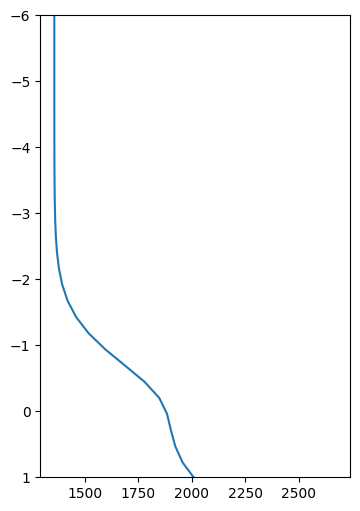

In [31]:
# T_int = 200. # interior temp, wasp-77
# T_eq = 1715. # equilibrium temp *** important
# radius = 1.5*const.R_jup
# log_gamma = -0.5 # *** important
# log_kappa = -1 # *** important

T_int = 500. # corot-2b
T_eq = 1535. # corot-2b
radius = 1.465*u.R_jup # corot-2b radius

log_gamma = -.6 # inversion (+ yes, - no) *** important
log_kappa = [-1.5] # *** important


for log_kappa in log_kappa:
    gravity = planet_obj.gp.cgs.value 
    kappa_IR = 10**(log_kappa)
    gamma = 10**log_gamma

    # gravity =planet_obj.gp.cgs.value 

    temp_params = {}
    temp_params['pressures'] = pressures
    temp_params['kappa_IR'] = kappa_IR
    temp_params['gamma'] = gamma
    temp_params['gravity'] = (const.G * planet_obj.M_pl / (radius)**2).cgs.value
    temp_params['T_int'] = T_int
    temp_params['T_eq'] = T_eq
    temp_params['M_pl'] = planet_obj.M_pl

    P0=10 *u.mbar.to(u.bar)
    # log_P0 = np.log10(P0)

    temperatures_day = guillot_global(temp_params['pressures'], 
                             temp_params['kappa_IR'], 
                             temp_params['gamma'], 
                             temp_params['gravity'], 
                             temp_params['T_int'], 
                             temp_params['T_eq'])
    
    plt.figure(figsize=(4,6))
    plt.plot(temperatures_day,np.log10(pressures))
    plt.ylim(1,-6)

### Another method to generate T-P profile

In [100]:
from scipy.interpolate import Akima1DInterpolator
import numpy as np

class AkimaProfileTP:
    
    def __init__(self, logp_nodes, t_nodes, top_isotherm=True):
        
        idx_sort = np.argsort(logp_nodes)
        logp_nodes = logp_nodes[idx_sort]
        t_nodes = t_nodes[idx_sort]
        
        # Add two points in top oof atmosphere to force isotherm
        if top_isotherm:
            d_logp = logp_nodes[1] - logp_nodes[0]
            top_t = [t_nodes[0], t_nodes[0]]
            top_p = [logp_nodes[0] - d_logp, logp_nodes[0] - d_logp/2]
            
            logp_nodes = np.append(top_p, logp_nodes)
            t_nodes = np.append(top_t, t_nodes)
            
        
        akima_spl = Akima1DInterpolator(logp_nodes, t_nodes)
        
        self.akima_spl = akima_spl
        self.logp_nodes = logp_nodes
        self.t_nodes = t_nodes
        
    def __call__(self, log_p):
        
        out = self.akima_spl(log_p, extrapolate=True)
        
        return out
    
# example:
logP = np.array([2, 0, -2, -4, -8])
temperature = np.array([2000, 2000, 3000, 3500, 2000])

# Generate profile
temp_akima = AkimaProfileTP(logP, temperature, top_isotherm=True)

# Finer grid for atmosphere model
p_grid = np.linspace(logP.min(), logP.max(), 100)
t_grid = temp_akima(p_grid)

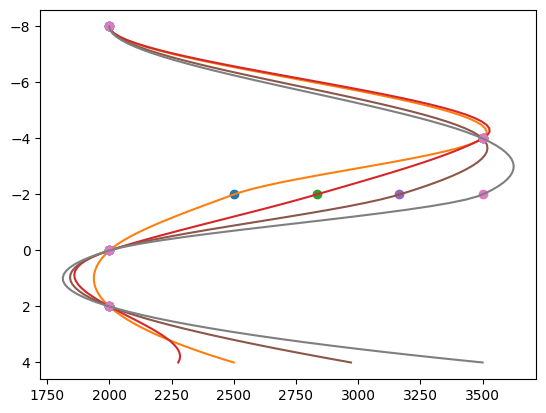

In [101]:
logP = np.array([2, 0, -2, -4, -8])
temperature = np.array([2000, 2000, 3000, 3500, 2000])


fig, ax = plt.subplots(1, 1)
ax.invert_yaxis()
for t_vary in np.linspace(2500, 3500, 4):
    temperature[2] = t_vary
    ax.plot(temperature, logP, 'o')

    temp_akima = AkimaProfileTP(logP, temperature, top_isotherm=True)

    p_plot = np.linspace(logP.min(), logP.max()+2, 100)
    t_plot = temp_akima(p_plot)
    ax.plot(t_plot, p_plot, '-')

1500.0
1833.3333333333333
2166.6666666666665
2500.0


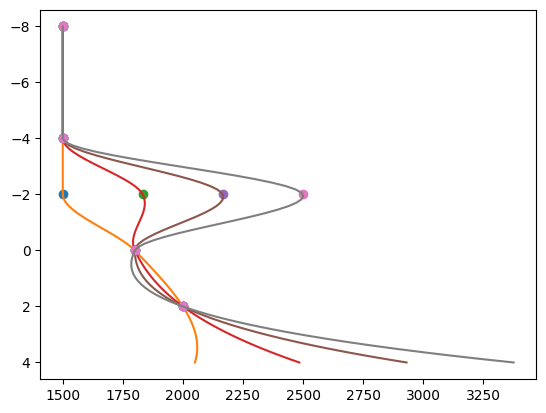

In [113]:
logP = np.array([2, 0, -2, -4, -8])
temperature = np.array([2000, 1800, 1600, 1500, 1500])


fig, ax = plt.subplots(1, 1)
ax.invert_yaxis()
for t_vary in np.linspace(1500, 2000, 4):
    print(t_vary)
    temperature[2] = t_vary
    ax.plot(temperature, logP, 'o')

    temp_akima = AkimaProfileTP(logP, temperature, top_isotherm=True)

    p_plot = np.linspace(logP.min(), logP.max()+2, 100)
    t_plot = temp_akima(p_plot)
    ax.plot(t_plot, p_plot, '-')

### CO only

In [32]:
%matplotlib inline

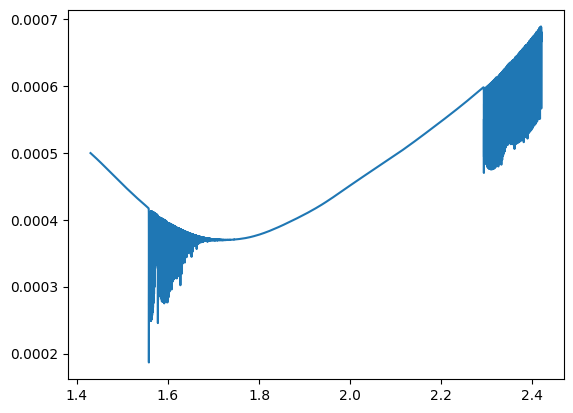

In [90]:
P0=10e-3

# GUESS PARAMETERS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cloud = None
mol_vmr_log = {'H2O':-99, # -10 too small, -1 a lot
               'CO':-3.77} # less CO, more negative
            #    'CO2':-99} # 
# IF ONLY WANT H2O, SET OTHER VARIABLES TO -99 (log_10(-99)~=0)

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_co = prt.prepare_model(wlen, flux_lambda, 250000, Raf=45000, rot_params=None) # Raf: resolution after
plt.plot(wave_mod, model_spec_co)

### H2O only

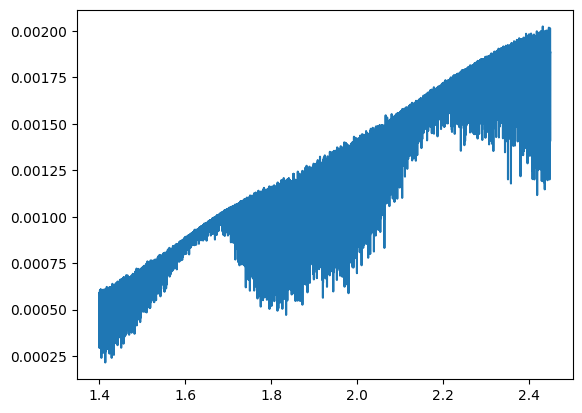

In [22]:
P0=10e-3

# GUESS PARAMETERS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cloud = None
mol_vmr_log = {'H2O':-3.93,
               'CO':-99}
# IF ONLY WANT H2O, SET OTHER VARIABLES TO -99 (log_10(-99)~=0)

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_h2o = prt.prepare_model(wlen, flux_lambda, 250000, Raf=45000, rot_params=None) # Raf: resolution after
plt.plot(wave_mod, model_spec_h2o)

### CO2 only

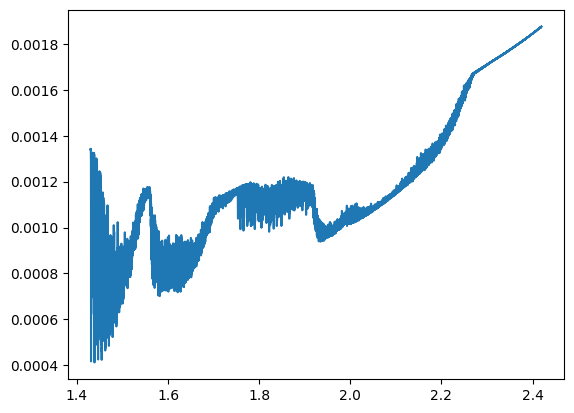

In [98]:
P0=10e-3

# GUESS PARAMETERS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cloud = None
mol_vmr_log = {'H2O':-99,
               'CO':-99,
               'CO2':-3}
# IF ONLY WANT H2O, SET OTHER VARIABLES TO -99 (log_10(-99)~=0)

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_co2 = prt.prepare_model(wlen, flux_lambda, 250000, Raf=45000, rot_params=None) # Raf: resolution after
plt.plot(wave_mod, model_spec_co2)

### CO and H2O

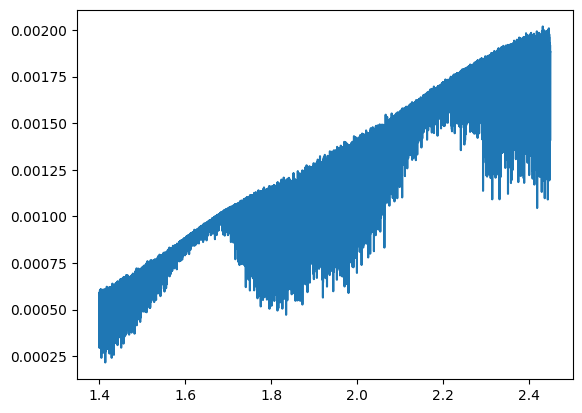

In [23]:
P0=10e-3

# GUESS PARAMETERS !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cloud = None
mol_vmr_log = {'H2O':-3.93, # -10 too small, -1 a lot
               'CO':-3.77} # less CO, more negative
# IF ONLY WANT H2O, SET OTHER VARIABLES TO -99 (log_10(-99)~=0)
# value from the paper

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_both = prt.prepare_model(wlen, flux_lambda, 250000, Raf=45000, rot_params=None) # Raf: resolution after
plt.plot(wave_mod, model_spec_both)

In [26]:
# list_wv_range = [(1.17, 1.25), (1.55, 1.9), (2.33, 3.)]


# fig, ax = plt.subplots(len(list_wv_range), 1)
# try:
#     len(ax)
# except TypeError:
#     ax = [ax]

# for ax_i, wv_rng in  zip(ax, list_wv_range):
#     cond = (wv_rng[0] < wave_mod) & (wave_mod < wv_rng[-1])
#     ax_i.plot(wave_mod[cond], (model_spec_co_day/model_spec_cont)[cond])

#### CH4 only

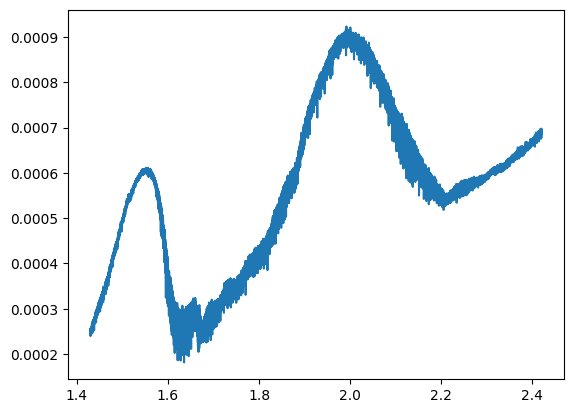

In [33]:
P0=10e-3
cloud = None
mol_vmr_log = {'CH4': -3,
                  'TiO': -99,
                  'VO': -99,
                  'Fe': -99}

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_ch4 = prt.prepare_model(wlen, flux_lambda, 250000, Raf=45000, rot_params=None) # Raf: resolution after
plt.plot(wave_mod, model_spec_ch4)

#### TiO only

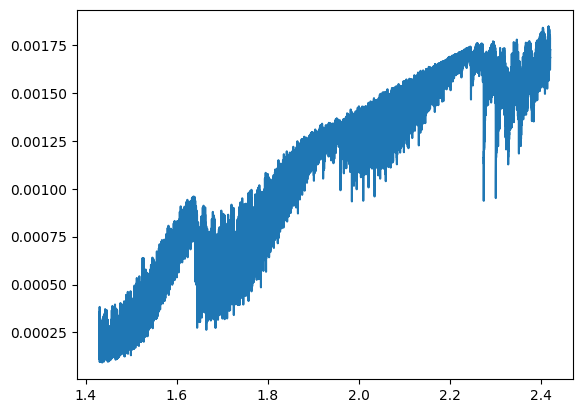

In [34]:
P0=10e-3
cloud = None
mol_vmr_log = {'CH4': -99,
                  'TiO': -3,
                  'VO': -99,
                  'Fe': -99}

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_tio = prt.prepare_model(wlen, flux_lambda, 250000, Raf=45000, rot_params=None) # Raf: resolution after
plt.plot(wave_mod, model_spec_tio)

#### VO only

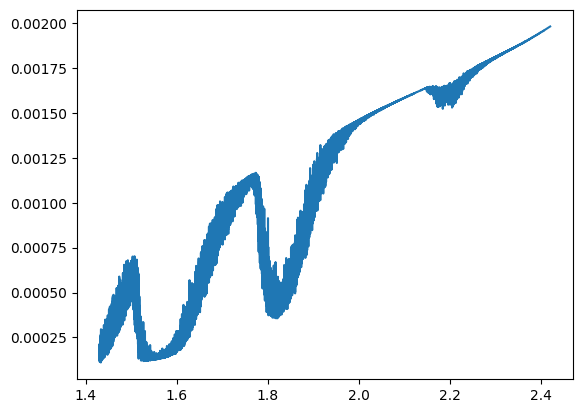

In [35]:
P0=10e-3
cloud = None
mol_vmr_log = {'CH4': -99,
                  'TiO': -99,
                  'VO': -3,
                  'Fe': -99}

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_vo = prt.prepare_model(wlen, flux_lambda, 250000, Raf=45000, rot_params=None) # Raf: resolution after
plt.plot(wave_mod, model_spec_vo)

#### Fe only

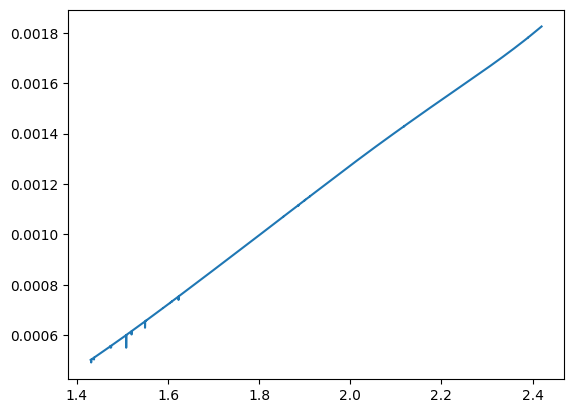

In [36]:
P0=10e-3
cloud = None
mol_vmr_log = {'CH4': -99,
                  'TiO': -99,
                  'VO': -99,
                  'Fe': -3}

# species_high = species_high0.copy()
species_high = {mols_linelists[mol_name]: 10**(mol_vmr_log[mol_name])
                for mol_name in molecules}

wlen, flux_lambda = prt.retrieval_model_plain(atmos_high,
                                              species_high,
                                              planet_obj,
                                              pressures,
                                              temperatures_day,
                                              temp_params['gravity'],
                                              P0,
                                              cloud,
                                              planet_obj.R_pl.cgs.value,
                                              planet_obj.R_star.cgs.value,
                                              kind_trans='emission')

wave_mod, model_spec_fe = prt.prepare_model(wlen, flux_lambda, 250000, Raf=45000, rot_params=None) # Raf: resolution after
plt.plot(wave_mod, model_spec_fe)

### Save

In [99]:
# np.savez('/home/ldang05/projects/def-dlafre/ldang05/Data/WASP-77Ab/test_mod_WASP-77_mixed_H2O_main_iso', wave_mod=wave_mod, model_spec=model_spec_h2o)
# np.savez('/home/ldang05/projects/def-dlafre/ldang05/Data/WASP-77Ab/test_mod_WASP-77_mixed_CO_main_iso', wave_mod=wave_mod, model_spec=model_spec_co)
# np.savez('/home/ldang05/projects/def-dlafre/ldang05/Data/WASP-77Ab/test_mod_WASP-77_mixed_H2O_CO_main_iso', wave_mod=wave_mod, model_spec=model_spec_both)
# np.savez('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b/test_mod_CoRoT-2b_mixed_CO2_main_iso', wave_mod=wave_mod, model_spec=model_spec_co2)
np.savez('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b/test_mod_CoRoT-2b_mixed_ch4_main_iso', wave_mod=wave_mod, model_spec=model_spec_ch4)
np.savez('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b/test_mod_CoRoT-2b_mixed_vo_main_iso', wave_mod=wave_mod, model_spec=model_spec_vo)
np.savez('/home/ldang05/projects/def-dlafre/ldang05/Data/CoRoT-2b/test_mod_CoRoT-2b_mixed_tio_main_iso', wave_mod=wave_mod, model_spec=model_spec_tio)